# **NLP For Finance: Exploration and Basic Models**

<img src="https://www.sr-sv.com/wp-content/uploads/2019/06/NLP_0000.jpg" width="800">

Natural language processing (NLP) enables us to analyze financial news
and evaluate the market sentiment. In the past, the volume of textual data was manageable enough to be manually analyzed by teams of human experts, but recent growth is intractable, so we need NLP to overcome this problem. In this project, we will go over different NLP techniques—from basic to advanced—and perform sentiment analysis over stock market news, categorizing the news into **positive**, **negative** or **neutral**.










In [6]:
#@title Run this to setup the libraries and download the dataset { display-mode: "form" }
# Run this every time you open the spreadsheet
%load_ext autoreload
%autoreload 2
from collections import Counter
from importlib.machinery import SourceFileLoader
import numpy as np
from os.path import join
import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('punkt')
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.corpus import stopwords
nltk.download('stopwords' ,quiet=True)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
import gdown
import string
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 100)
from sklearn.feature_extraction.text import CountVectorizer


nltk.download('wordnet')

gdown.download('https://drive.google.com/uc?id=1q4U2gVY9tWEPdT6W-pdQpKmo152QqWLE', 'finance_train.csv', True)
gdown.download('https://drive.google.com/uc?id=1nIBqAsItwVEGVayYTgvybz7HeK0asom0', 'finance_test.csv', True)

#!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv'
#!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv'

def get_finance_train():
  df_train = pd.read_csv("finance_train.csv")
  return df_train
def get_finance_test():
  df_test = pd.read_csv("finance_test.csv")
  return df_test

def plot_word_cloud(text):
  text = text.Sentence.values
  wordcloud = WordCloud(
      width = 3000,
      height = 2000,
      background_color = 'black',
      stopwords = STOPWORDS).generate(str(text))
  fig = plt.figure(
      figsize = (10, 7),
      facecolor = 'k',
      edgecolor = 'k')
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show()

def preprocess_data(df):
  sentences = df.Sentence.values
  labels = df.Label.values
  tokenized_sentences = [word_tokenize(word) for word in sentences]
  filtered_sentences = [remove_stopwords(word) for word in tokenized_sentences]
  return filtered_sentences, labels

def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = ["Negative","Neutral","Positive"]
  df_cm = pd.DataFrame(cm,index =labels,columns = labels)
  fig = plt.figure(figsize=(14,12))
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.close()

LABEL_MAP = {0 : "negative", 1 : "neutral", 2 : "positive"}
STOPWORD_SET = set(stopwords.words('english'))
SAMPLE_SENTENCE = word_tokenize('I need to remove all these meaningless stopwords.')
SAMPLE_SOLUTION = ['I', 'need', 'remove', 'meaningless', 'stopwords', '.']


print ("Train & Test Files are loaded")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to /Users/shyryn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/shyryn/nltk_data...


Train & Test Files are loaded


# **Milestone 2: Apply NLP pre-processing techniques to filter our datasets.**

### **Exploring the Datasets**

Before we can filter our datasets, let us first read them in and explore.

In [7]:
df_train = get_finance_train()
print(df_train.head())

                                                                                              Sentence  \
0                                                 Autotank Group is part of Aspo 's Systems Division .   
1  The contract includes design , construction , delivery of equipment , installation and commissio...   
2  Rapala said it estimates it will make savings of 1-2 mln eur a year by centralising its French o...   
3  The share capital of Alma Media Corporation (business ID 1944757-4)is EUR 45,031,513.80 and it i...   
4  The financial impact is estimated to be some 1.5 MEUR annual improvement in the division 's resu...   

   Label  
0      1  
1      1  
2      2  
3      1  
4      2  


In [8]:

print('There are a total of {} examples in the Finance Train dataset.'.format(df_train.shape[0]))

There are a total of 2037 examples in the Finance Train dataset.


In [9]:
df_test = get_finance_test()
print(df_test.head())

                                                                                              Sentence  \
0  In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating prof...   
1  Foundries division reports its sales increased by 9.7 % to EUR 63.1 mn from EUR 57.5 mn in the c...   
2                                               Financing of the project will come mainly from China .   
3  Sukhraj Dulai , of the 2900 block of Boni Sue Court , a cul-de-sac on the city 's north side , s...   
4  Finland 's leading metals group Outokumpu said its fourth-quarter net profit more than tripled o...   

   Label  
0      2  
1      2  
2      1  
3      1  
4      2  


In [10]:

print('There are a total of {} examples in the Finance Test dataset.'.format(df_test.shape[0]))

There are a total of 227 examples in the Finance Test dataset.


In [11]:
print(LABEL_MAP)

{0: 'negative', 1: 'neutral', 2: 'positive'}


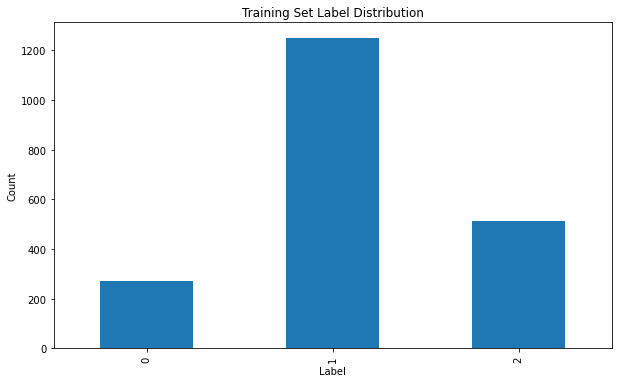

In [12]:
fig = plt.figure(figsize=(10,6))
plt.title('Training Set Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')

df_train.groupby('Label').Sentence.count().plot.bar(ylim=0)

plt.show()

In [13]:
negative_data = df_train[df_train['Label'] == 0]

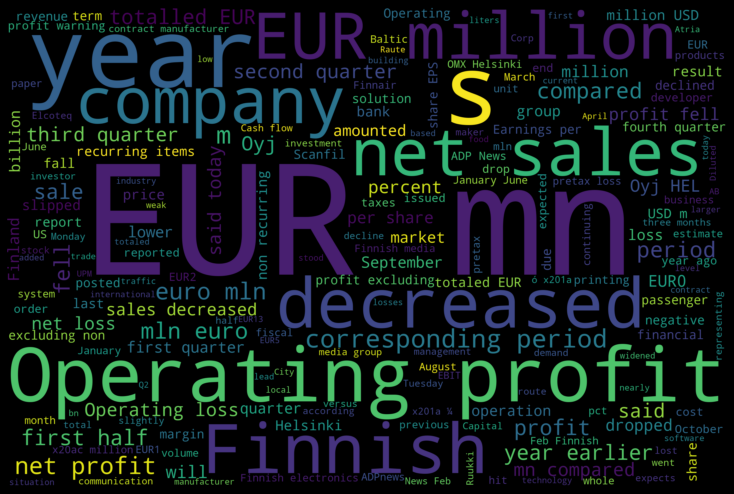

In [14]:
plot_word_cloud(negative_data)

In [15]:
positive_data = df_train[df_train['Label'] == 2]

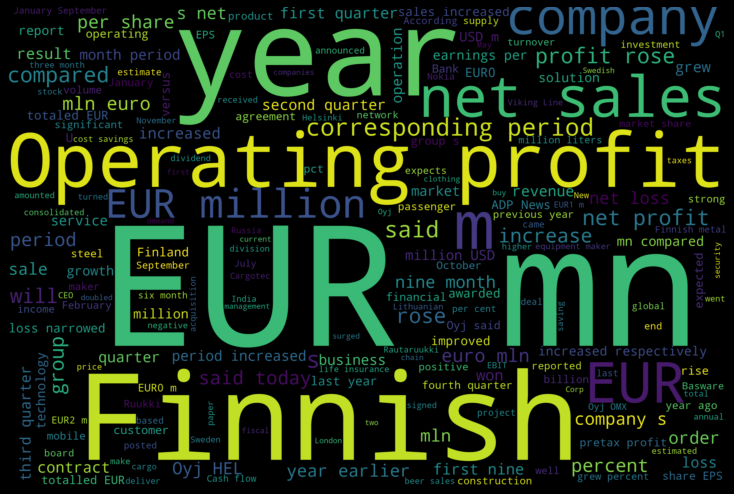

In [16]:
plot_word_cloud(positive_data)

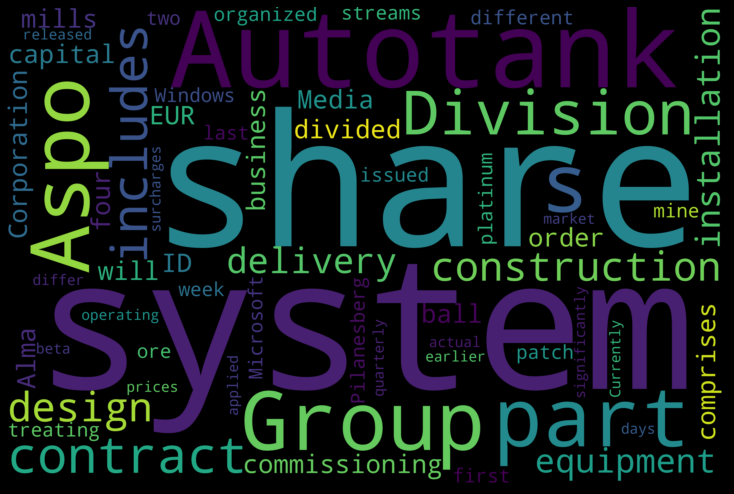

In [17]:
neutral_data = df_train[df_train['Label'] == 1]
plot_word_cloud(neutral_data)

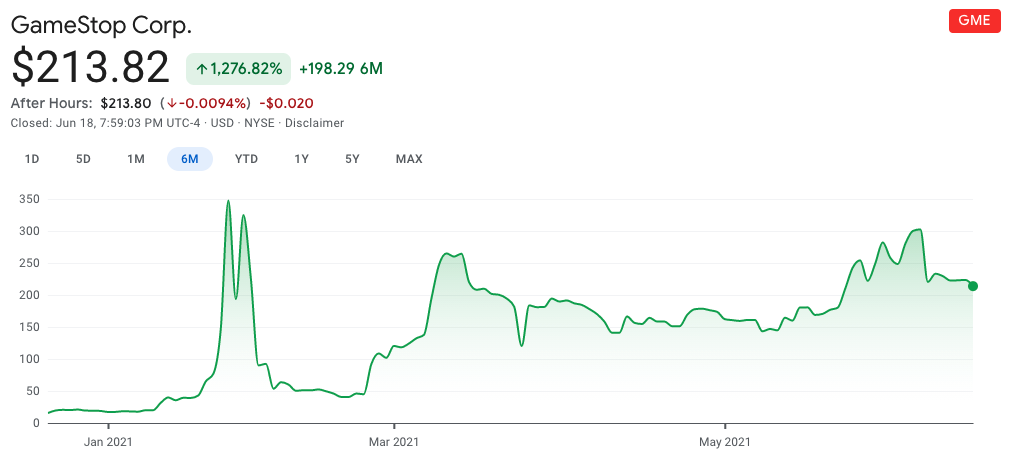

Stock price prediction using sentiment analysis is a well explored field, as you can read more about [here](https://medium.com/vsinghbisen/how-sentiment-analysis-in-stock-market-used-for-right-prediction-5c1bfe64c233). Before we can effectively create models to predict stock prices using sentiment analysis, we need to be able to accurately analyze sentiment of financial news. That will be our focus in these notebooks with the aim to create the best sentiment analysis financial news prediction models!

In [18]:
print(STOPWORD_SET)

{"don't", "you've", "you'll", 'between', 'when', 'will', 'own', 'off', 'his', 'below', 'been', 'where', 'than', 'shan', 'because', 'before', 'further', 'they', 'shouldn', 'why', "haven't", 'until', 'did', 're', "mustn't", 'yourselves', 'himself', 't', 'doing', 'just', 'mightn', 'there', 'hers', 'so', 'and', "shouldn't", 'can', 'itself', 'didn', 'him', 'too', 'now', 'doesn', 'these', 'out', 'few', 'again', 'had', 'against', 'over', 'up', 'themselves', 'about', "isn't", 'that', 'do', "doesn't", "hadn't", 'by', 'haven', 'me', 'm', 'herself', 'other', 'any', 'her', 'y', 'on', 'who', "she's", 'of', 'were', 'for', 'above', 'then', 'it', 'only', 'isn', 'was', 'both', "needn't", "shan't", 'into', "wouldn't", 'more', 'to', 'weren', 'such', "hasn't", 'how', 'i', 'here', 'from', 'does', "aren't", 'each', 'their', 'while', 'its', "mightn't", 'this', 'theirs', "weren't", 'no', 'needn', 'ma', 'yours', 'the', 'same', 'we', 'hadn', 'don', 'those', 'which', 'them', 'she', 'ain', 'won', "couldn't", 'has

In [19]:
#@title Check If Stopword { run: "auto", vertical-output: true, display-mode: "form" }
word = "stopword\"" #@param {type:"string"}
if not word: raise Exception('Please enter a word')
eng_stopwords = set(stopwords.words('english'))
if word[:-1].lower().strip() in eng_stopwords: print('Yes,\"{}'' is a stopword.'.format(word))
else: print('No,\"{}'' is NOT a stopword.'.format(word))



No,"stopword" is NOT a stopword.


In [20]:
#@title Sample Input and Output

print('Sample Input:\t{}'.format(SAMPLE_SENTENCE))
print('Sample Output:\t{}'.format(SAMPLE_SOLUTION))

Sample Input:	['I', 'need', 'to', 'remove', 'all', 'these', 'meaningless', 'stopwords', '.']
Sample Output:	['I', 'need', 'remove', 'meaningless', 'stopwords', '.']


In [21]:
def remove_stopwords(tokenized_sentence):
  filtered_sentence = []
  for w in tokenized_sentence:
    if w not in STOPWORD_SET: filtered_sentence.append(w)
  return filtered_sentence

**Try calling your code on the sentence from above, named `SAMPLE_SENTENCE`, to verify that you get the same output!**

In [22]:
remove_stopwords(SAMPLE_SENTENCE)

['I', 'need', 'remove', 'meaningless', 'stopwords', '.']

In [23]:
train_sentences, train_labels = preprocess_data(df_train)
for sentence in train_sentences[:3]:
    print(sentence)

['Autotank', 'Group', 'part', 'Aspo', "'s", 'Systems', 'Division', '.']
['The', 'contract', 'includes', 'design', ',', 'construction', ',', 'delivery', 'equipment', ',', 'installation', 'commissioning', '.']
['Rapala', 'said', 'estimates', 'make', 'savings', '1-2', 'mln', 'eur', 'year', 'centralising', 'French', 'operations', 'one', 'site', '.']


In [24]:
test_sentences, test_labels = preprocess_data(df_test)
for sentence in test_sentences[:3]:
    print(sentence)

['In', 'third', 'quarter', '2010', ',', 'net', 'sales', 'increased', '5.2', '%', 'EUR', '205.5', 'mn', ',', 'operating', 'profit', '34.9', '%', 'EUR', '23.5', 'mn', '.']
['Foundries', 'division', 'reports', 'sales', 'increased', '9.7', '%', 'EUR', '63.1', 'mn', 'EUR', '57.5', 'mn', 'corresponding', 'period', '2006', ',', 'sales', 'Machine', 'Shop', 'division', 'increased', '16.4', '%', 'EUR', '41.2', 'mn', 'EUR', '35.4', 'mn', 'corresponding', 'period', '2006', '.']
['Financing', 'project', 'come', 'mainly', 'China', '.']


# **Milestone 3: Build a baseline model for the task of financial news sentiment classification.**

In [ ]:
#@title Exploration Exercise: Brainstorm the benefits of a Logistic Regression model and why it may be useful to use for this application?

_1_ = '' #@param {type:"string"}
_2_ = '' #@param {type:"string"}
_3_ = '' #@param {type:"string"}

print('1: It is a simple baseline models that tells us how much room there is to improve.')
print('2: Model iteration is quick and easy.')
print('3: Logistic regression is interpretable. It is often extremely important that you are able to understand why a model is making specific predictions, and Logistic Regression gives us this ability.')

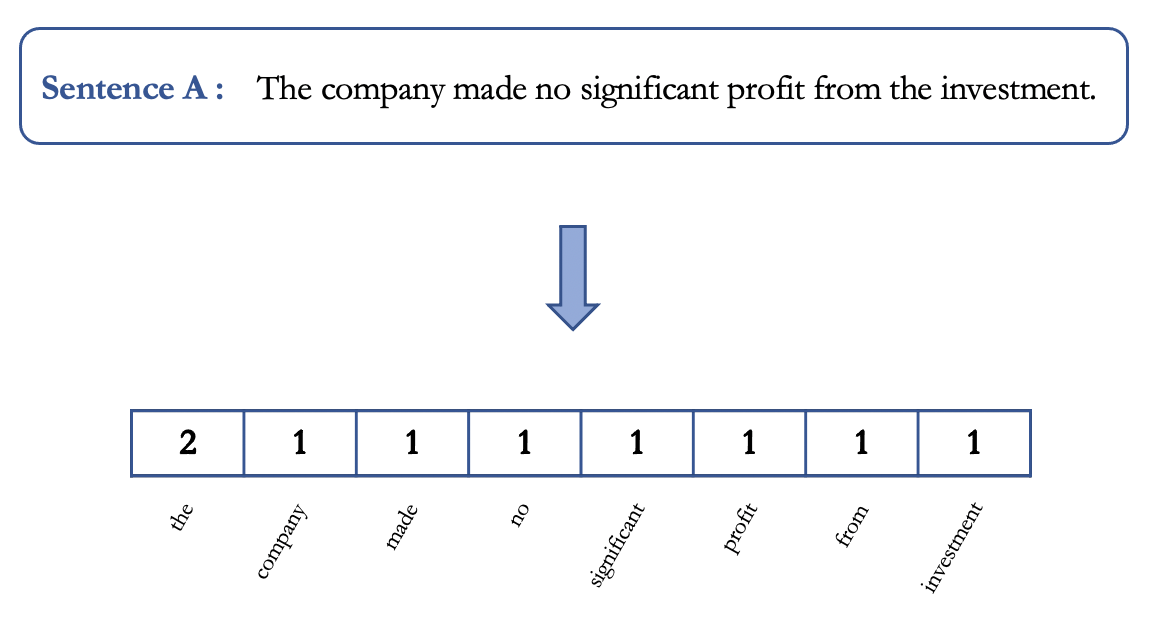

In [25]:
# List of sentences
all_sentences = ["Google AI made remarkable achievements in 2019.", "Google Stock was at its all time high"]

#Create instance of CountVectorizer() object
vectorizer = CountVectorizer()

In [26]:
# Tokenizes the text and builds the vocabulary
vectorizer.fit(all_sentences)

CountVectorizer()

In [27]:
# Encode sentences as a vectors
bag_of_words_matrix = vectorizer.transform(all_sentences).toarray()

# Print vectors
print(bag_of_words_matrix)

[[1 1 1 0 0 1 0 1 0 1 1 0 0 0]
 [0 0 0 1 1 1 1 0 1 0 0 1 1 1]]


In [28]:
print(bag_of_words_matrix.shape)

(2, 14)


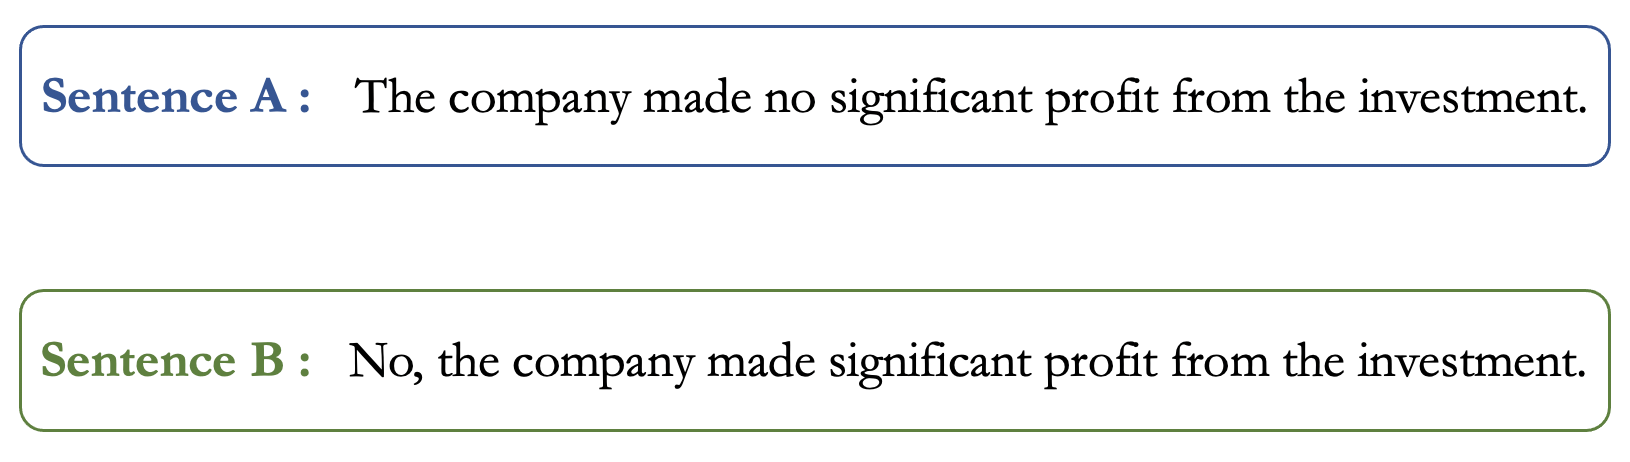

In [ ]:
#@title Exercise. Sentence Sentiment? { display-mode: "form" }

#@markdown What sentiment would you assign Sentence A? 
A  = "" #@param ["positive", "negative", "neutral", ""]

#@markdown What sentiment would you assign Sentence B? 
B = '' #@param ["positive", "negative", "neutral", ""]

  
if A == "negative":
  print("Yes, since the company did not profit you can interpret this as being negative! You could also interpret it as neutral.")
elif A == "neutral":
  print("Yes, since the company did not profit you can interpret this as being neutral! You could also interpret it as negative.")
else:
  print('Not quite the right sentiment!')
if B == "positive":
  print("Yes, since the company made significant profits you can interpret that as being positive!")
else:
  print('Not quite the right sentiment!')


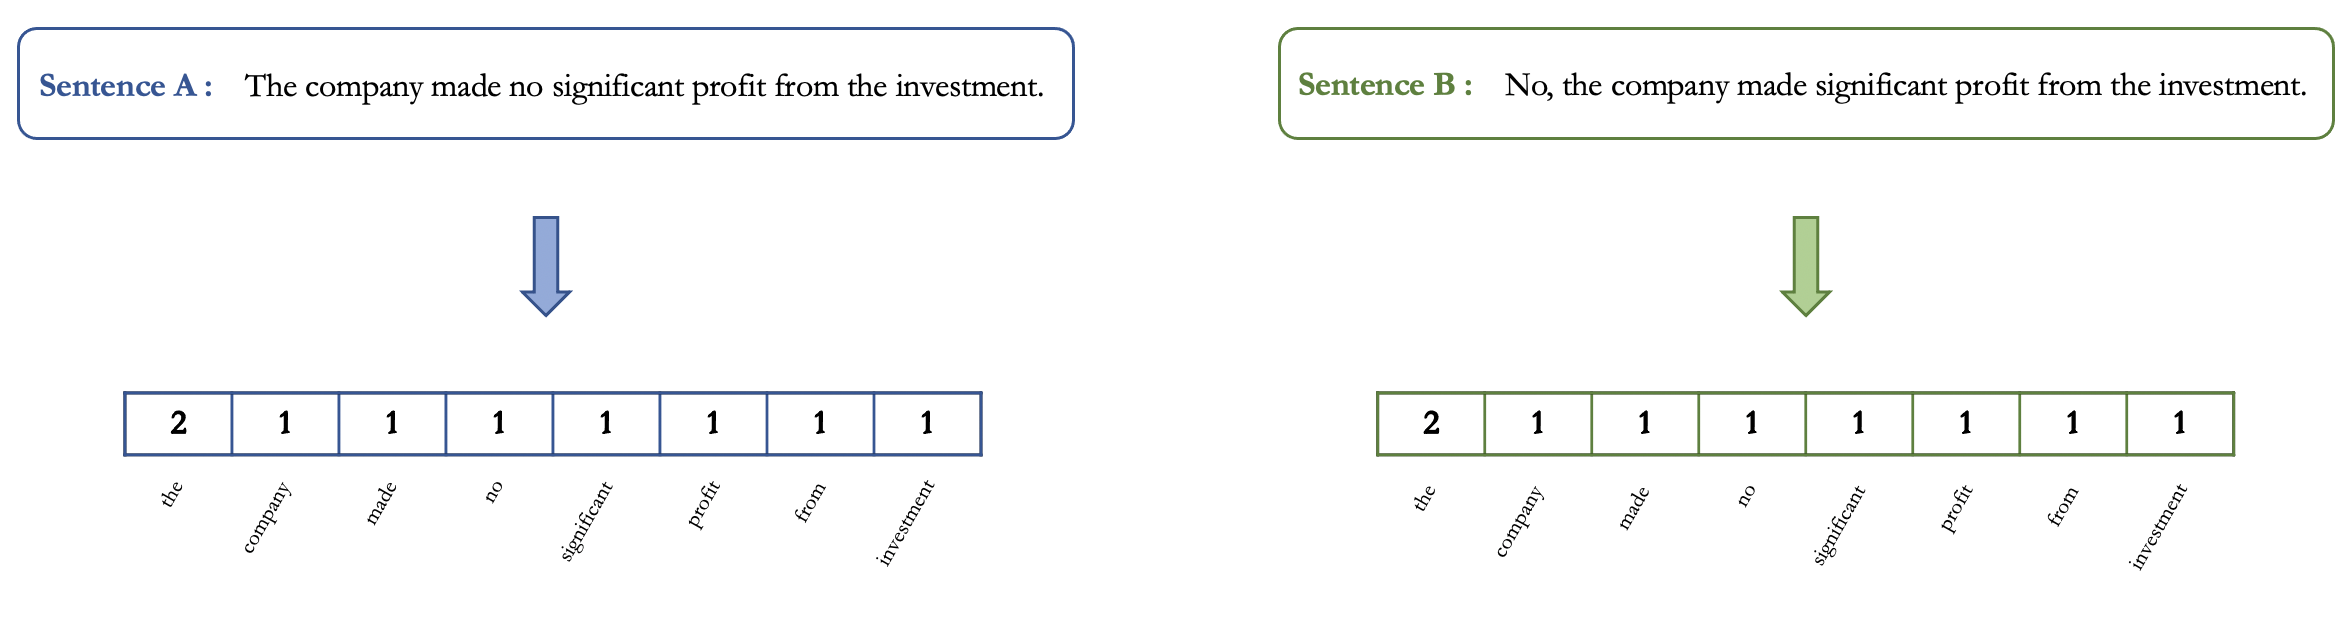

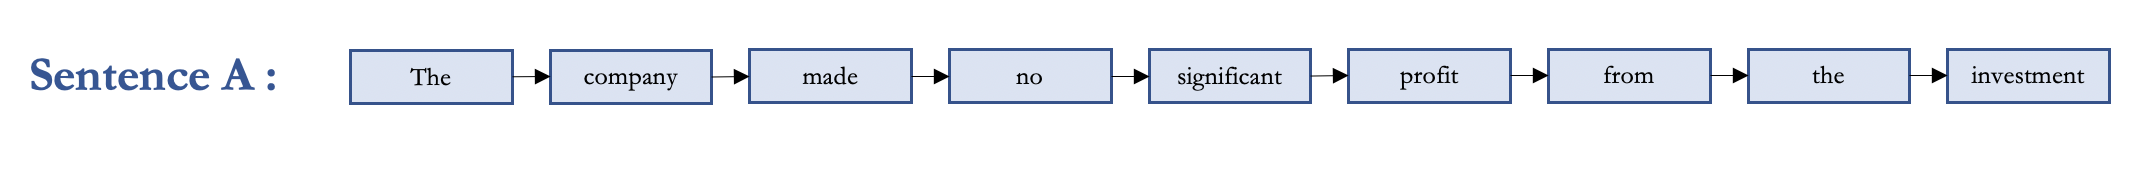

Instead of immediately generating a sentence-level representation given the frequency of words, we will tackle the process of generating a representation more iteratively with LSTMs. Imagine starting with an empty vector representation for the sentence of size 256 called **C**

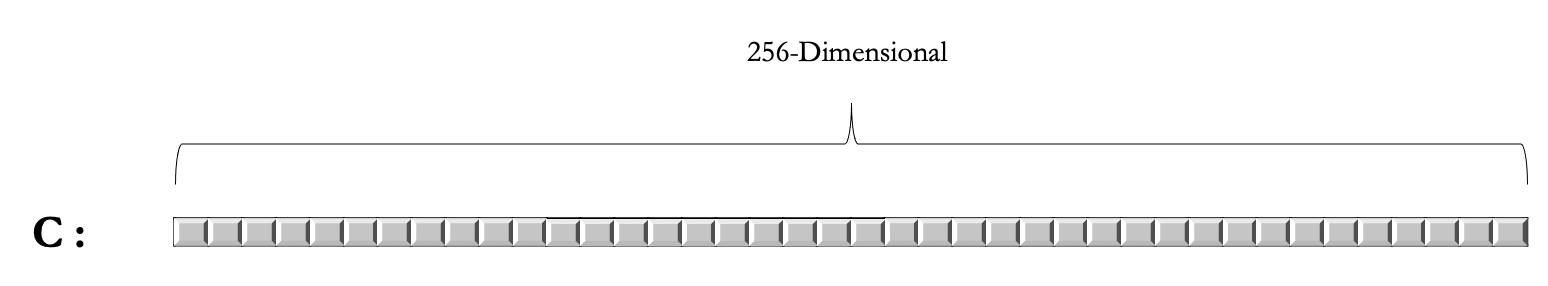

We start **R** at the beginning of the sentence sequence and iterate it through each of the words. Every time we arrive at a word, we update the **C** vector intelligently to capture sentence structure, the current word, and more. 

This brings us to the very definition of LSTM. LSTM stands for long short-term memory network. It learns the long-term dependencies in a sentence through this sequence-level interpretation. Thus, we pass our vector **C** through the sequence and learn some long term representation **C*** of our sentence. Each word and the words directly before it are what we refer to as the short term memory part of the LSTM.

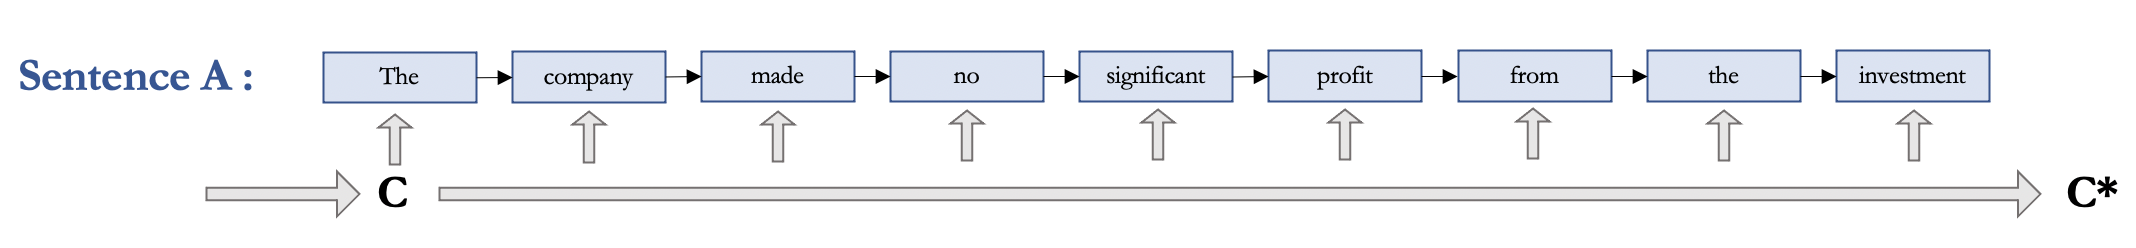

# **Milestone 2: Building and evaluating an LSTM model from processed data.**

In [ ]:
#@title Run this to load the datasets and setup the environment. { display-mode: "form" }
# Run this every time you open the spreadsheet
%load_ext autoreload
%autoreload 2
from collections import Counter
from importlib.machinery import SourceFileLoader
import numpy as np
from os.path import join
import warnings
warnings.filterwarnings("ignore")
from torchtext.vocab import GloVe
import nltk
nltk.download('punkt')
import seaborn as sns
import matplotlib

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.corpus import stopwords
nltk.download('stopwords' ,quiet=True)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
import gdown
import string
import numpy
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import string


def get_finance_train():
  df_train = pd.read_csv("finance_train.csv")
  return df_train
def get_finance_test():
  df_test = pd.read_csv("finance_test.csv")
  return df_test

PUNCTUATION = '!#$%&()*,-./:;<=>?@^_`{|}~'

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

def pad_sequences_train(df_train, df_test):
  tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
  tokenizer.fit_on_texts(df_train['Sentence'].values)
  word_index = tokenizer.word_index
  X = tokenizer.texts_to_sequences(df_train['Sentence'].values)
  X_train = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
  return X_train

def pad_sequences_test(df_train, df_test):
  tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
  tokenizer.fit_on_texts(df_train['Sentence'].values)
  word_index = tokenizer.word_index
  X = tokenizer.texts_to_sequences(df_test['Sentence'].values)
  X_test = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
  return X_test

def run_model(X_train, y_train, X_test, y_test, epochs=5, max_sequence_length=256, max_nb_words=1000, embedding_dim=300):
  if any(x is None for x in [X_train, y_train, X_test, y_test, epochs, max_sequence_length, max_nb_words, embedding_dim]):
    print('Replace the None values above with your new values before calling the run_model() function.')
    return None, None, None
  model = Sequential()
  model.add(Embedding(max_nb_words+1, embedding_dim, mask_zero=True, input_length=max_sequence_length))
  model.add(SpatialDropout1D(0.2))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(n_labels, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  history = model.fit(X_train, 
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
  test_loss, test_accuracy = model.evaluate(X_test, y_test)
  return model, history, test_accuracy


EMBEDDING_DIM = 300


nltk.download('wordnet')

#!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv'
#!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv'

print ("Train & Test Files are loaded")

In [ ]:
df_train = get_finance_train()
print(df_train.head())

In [ ]:
longest_sentence_index = np.argmax([len(x) for x in df_train['Sentence'].str.split(' ')])
longest_sentence = df_train.iloc[longest_sentence_index]['Sentence']
longest_sentence_length = len(longest_sentence.split(' '))
print('The longest sentence has length {} and is: \n\n{}'.format(longest_sentence_length, longest_sentence))

In [ ]:
df_test = get_finance_test()
print(df_test.head())

In [ ]:
print(PUNCTUATION)

In [ ]:
sample_sentence = 'There, is-! a# lo?t of< pu>=nctuat-io!n he~re!'
print(sample_sentence)

In [ ]:
PUNCTUATION_RE = re.compile("[%s]" % PUNCTUATION)

In [ ]:
filtered_sample_sentence = PUNCTUATION_RE.sub("", sample_sentence)
print(filtered_sample_sentence)

In [ ]:
example_sentence = 'No, th-at:/- is not,. how you w.rite a] pr!op$er sen^*tence'
print(example_sentence)
print(clean_text(example_sentence))

In [ ]:
train_example = df_train.iloc[100]['Sentence']
print(train_example)
print(clean_text(train_example))

In [ ]:

df_train['Sentence'] = df_train['Sentence'].apply(clean_text)
df_test['Sentence'] = df_test['Sentence'].apply(clean_text)

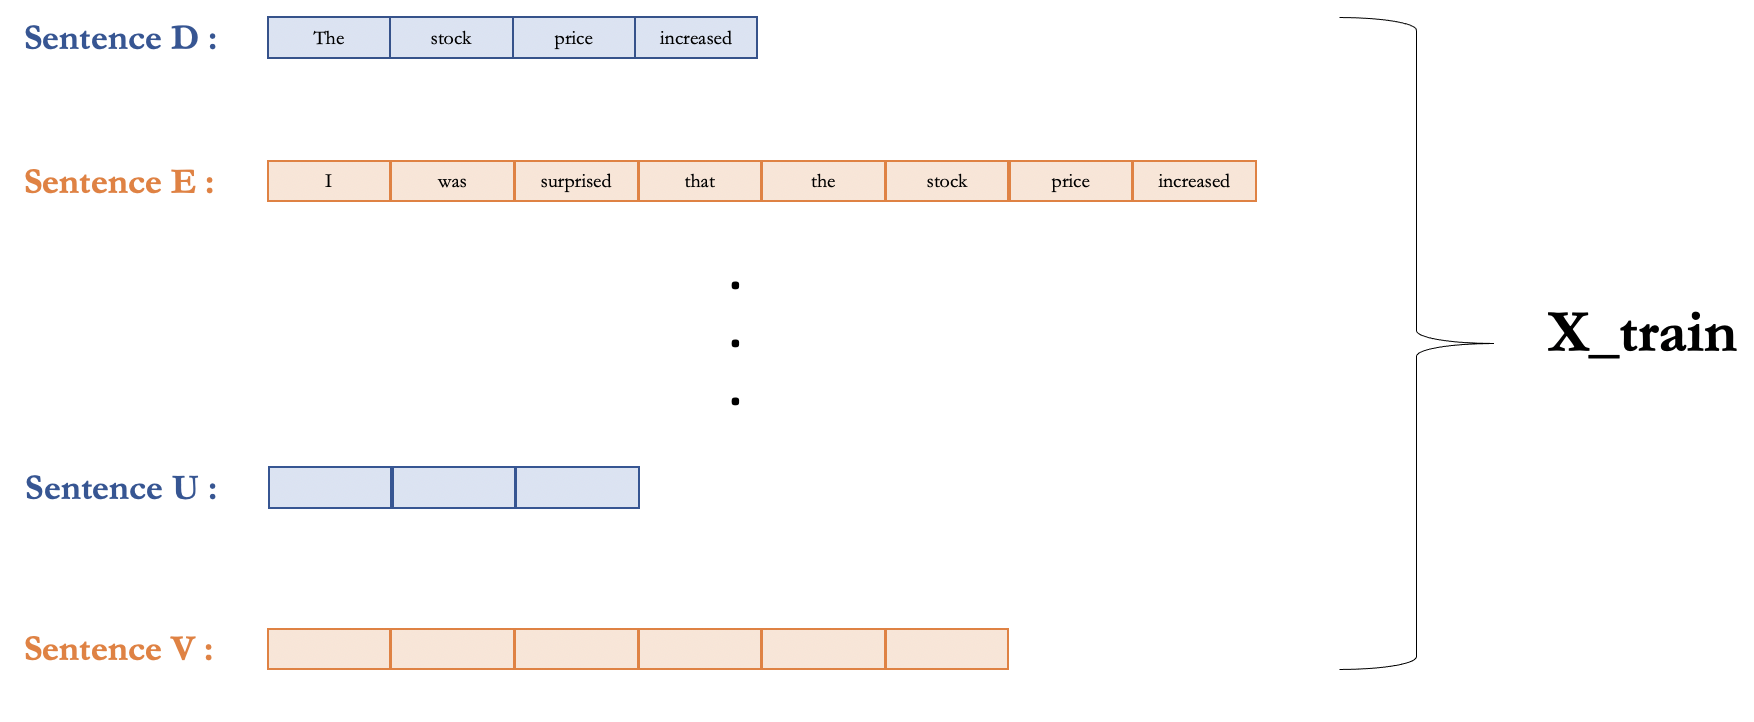

So, we will resolve that by adding empty features, or what is referred to as the padding, to smaller sentences such that all sentences will be the same length!

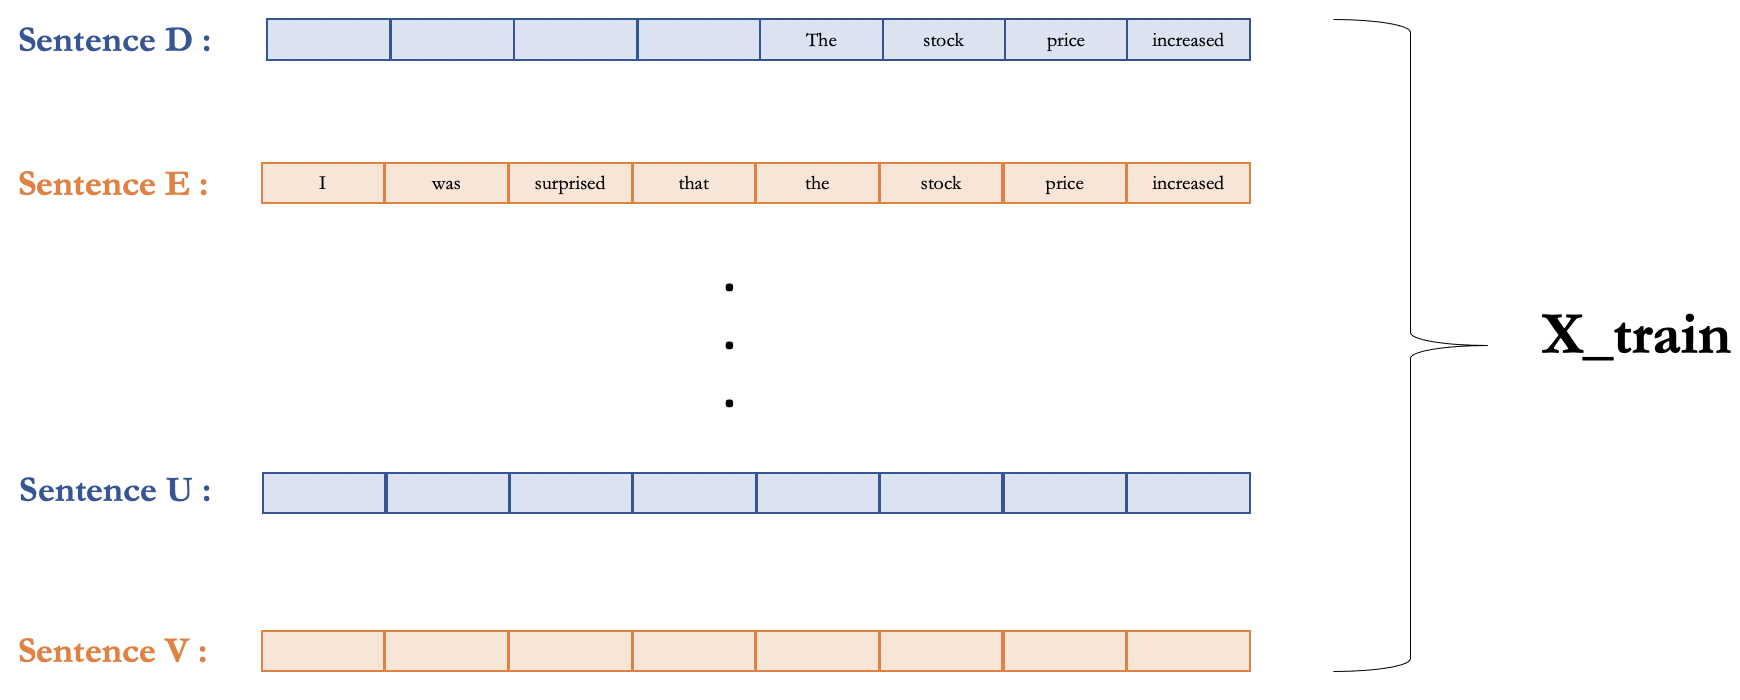



We will capture this property of the length that we want all the sequences to be padded to in a variable called `MAX_SEQUENCE_LENGTH` and will set it to `256` to be able to capture sentences of maximum length `256` in our model.

In [ ]:
MAX_SEQUENCE_LENGTH = 256

In addition to a max sequence length, we want to tell our LSTM model how many possible words in the vocab it should expect to properly create our representation. We will save this value in a variable named `MAX_NB_WORDS`, set it equal to `1000`, and pass it to our LSTM model.

In [ ]:
MAX_NB_WORDS = 1000

In [ ]:

X_train = pad_sequences_train(df_train, df_test)
print('The shape of the dataframe is {}'.format(X_train.shape))
print(X_train[0])

In [ ]:
X_test = pad_sequences_test(df_train, df_test)
print('The shape of the dataframe is {}'.format(X_test.shape))

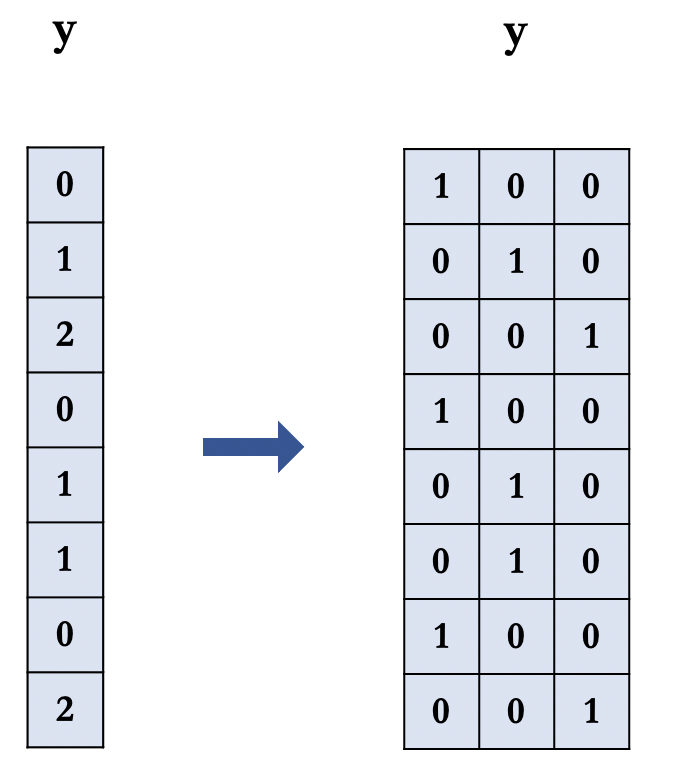

In [ ]:
y_train = pd.get_dummies(df_train['Label']).values
print(y_train.shape)

In [ ]:
y_test = pd.get_dummies(df_test['Label']).values
print(y_test.shape)

In [ ]:
n_labels = 3
label_map = {0 : "negative", 
             1 : "neutral",
             2 : "positive"}

In [ ]:

model = Sequential()
model.add(Embedding(MAX_NB_WORDS+1, EMBEDDING_DIM, mask_zero=True, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
epochs = 5
batch_size = 64

In [ ]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [ ]:

test_loss, test_accuracy = model.evaluate(X_test, y_test)


In [ ]:
training_loss = history.history['loss']

In [ ]:
validation_loss = history.history['val_loss']

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(training_loss, label='train')
plt.plot(validation_loss, label='validation')

plt.legend()
plt.show()

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.title('Accuracy over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(training_accuracy, label='train')
plt.plot(validation_accuracy, label='validation')

plt.legend()
plt.show()

In [ ]:
model, history, test_acc = run_model(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    epochs=6,
    max_sequence_length=256,
    max_nb_words=1500,
    embedding_dim=280
)
print('New test accuracy is {}'.format(test_acc))

In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
!pip install transformers
import os
import gdown
import torch
import numpy as np
import transformers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

% matplotlib inline

# gdown.download('https://drive.google.com/uc?id=1q4U2gVY9tWEPdT6W-pdQpKmo152QqWLE', 'finance_train.csv', True)
# gdown.download('https://drive.google.com/uc?id=1nIBqAsItwVEGVayYTgvybz7HeK0asom0', 'finance_test.csv', True)

#!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv'
#!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv'



def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

print ("Train and Test Files Loaded as train.csv and test.csv")

LABEL_MAP = {0 : "negative", 1 : "neutral", 2 : "positive"}
NONE = 4 * [None]
RND_SEED=2020




In [ ]:
df_train = get_finance_train()
df_test = get_finance_test()

In [ ]:
sentences = df_train['Sentence'].values
labels = df_train['Label'].values

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)

In [ ]:
print(tokenizer.vocab_size)

In [ ]:
original_sentence = sentences[0]
tokenized_sentence = tokenizer.tokenize(original_sentence)
print('Original Sentence: ', original_sentence)
print('Tokenized Sentence: ', tokenized_sentence)

In [ ]:
original_sentence = sentences[0]
tokenized_sentence = tokenizer.tokenize(original_sentence)
print('Tokenized Sentence: ', tokenized_sentence)
print('Mapped Indices Sentence: ', tokenizer.convert_tokens_to_ids(tokenized_sentence))

![picture](https://drive.google.com/uc?id=1sN5pvRjF1PnV72AXu9d8DLVDllAYOBzk)

These are two tokens we add to the start and end respectively:



*   `[CLS]` - stands for "classification," and is used to identify new sentences.
*   `[SEP]` - stands for "separator," and identifies if a pair of sentences are consecutive in a corpus or not (used for next sentence prediction).



In [ ]:
sentences_with_special_tokens = []
for sentence in sentences:
  new_sentence = "[CLS] " + sentence + " [SEP]"
  sentences_with_special_tokens.append(new_sentence)
print(sentences_with_special_tokens[0])

In [ ]:
tokenized_texts = []
for sentence in sentences_with_special_tokens:
  tokenized_sentence = tokenizer.tokenize(sentence)
  tokenized_texts.append(tokenized_sentence)
print(tokenized_texts[0])

In [ ]:
input_ids = []
for text in tokenized_texts:
  new_list = tokenizer.convert_tokens_to_ids(text)
  input_ids.append(new_list)
print(input_ids[0])

In [ ]:
input_ids = pad_sequences(input_ids, 
                          maxlen=128,
                          dtype="long",
                          truncating="post", 
                          padding="post")
print(input_ids[0])

![picture](https://drive.google.com/uc?id=1LgtkmZU8fQZsn9L85lENHgGxej3i61TP)

In [ ]:
attention_masks = []
for sequence in input_ids:
  mask = [float(i > 0) for i in sequence]
  attention_masks.append(mask)
print (attention_masks[0])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(input_ids, 
                                                  labels,
                                                  test_size=0.15, 
                                                  random_state=RND_SEED)

In [ ]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids, 
                                                       test_size=0.15,
                                                       random_state=RND_SEED)

In [ ]:
train_inputs = torch.tensor(np.array(X_train));
validation_inputs = torch.tensor(np.array(X_val));
train_masks = torch.tensor(np.array(train_masks));
validation_masks = torch.tensor(np.array(validation_masks));
train_labels = torch.tensor(np.array(y_train));
validation_labels = torch.tensor(np.array(y_val));

batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels);
train_sampler = RandomSampler(train_data); # Samples data randonly for training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size);
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels);
validation_sampler = SequentialSampler(validation_data); # Samples data sequentially
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size);

In [ ]:

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT small model, with an uncased vocab.
    num_labels = 3,    
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
);

model.cuda();

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )
epochs = 4

In [ ]:

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

training_loss = []
validation_loss = []
training_stats = []
for epoch_i in range(0, epochs):
    # Training
    print('Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training the model')
    # Reset the total loss for  epoch.
    total_train_loss = 0
    # Put the model into training mode. 
    model.train()
    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 20 == 0 and not step == 0:
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)  

       
        model.zero_grad()    

     
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    # Validation
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("Evaluating on Validation Set")
    # Put the model in evaluation mode
    model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        #Step 1 and Step 2
        # Unpack this validation batch from our dataloader. 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Validation Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    
    
    print("Validation Loss: {0:.2f}".format(avg_val_loss))
    

    training_loss.append(avg_train_loss)
    validation_loss.append(avg_val_loss)
    # Record all statistics from this epoch.
    
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy
            
        }
    )
    
print("Training complete!")

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(training_loss, label='train')
plt.plot(validation_loss, label='validation')

plt.legend()
plt.show()

In [ ]:
test_sentences = df_test.Sentence.values
test_labels = df_test.Label.values

In [ ]:
test_input_ids, test_attention_masks = [], []

# Add Special Tokens
test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]

# Tokenize sentences
tokenized_test_sentences = [tokenizer.tokenize(sent) for sent in test_sentences]

# Encode Tokens to Word IDs
test_input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_test_sentences]

# Pad the inputs
test_input_ids = pad_sequences(test_input_ids, 
                               maxlen=128, 
                               dtype="long",
                               truncating="post", 
                               padding="post")

# Create Attention Masks
for sequence in test_input_ids:
  mask = [float(i>0) for i in sequence]
  test_attention_masks.append(mask)

In [ ]:
batch_size = 32  
test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

  
print ('Test Accuracy: {:.2%}'.format(flat_accuracy(logits, label_ids)))